In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import re
import networkx as nx
from geopy.geocoders import Nominatim
from pyvis.network import Network
import requests

from networkx.algorithms import community

In [ ]:
with open("friends.txt", encoding="UTF8") as file:
    friends = file.read()

In [ ]:
my_friends_list = re.findall(r'Node\n\n(.*)', friends)
print('Count of nodes: ', len(my_friends_list))
assert len(my_friends_list) == len(set(my_friends_list)), 'Duplicates detected!'

In [ ]:
splitted_friends = re.split(r'Node\n\n(.*)', friends)
edge_dict = {}
node = None
for i in splitted_friends:
    if splitted_friends.index(i) % 2 == 1:
        node = i
    else:
        edge_dict[node] = i
print('Count of elements in dict: ', len(edge_dict))

In [ ]:
edge_frame = pd.DataFrame.from_dict(edge_dict, orient='index', columns=['target']).reset_index().rename(columns={"index": "source"})
edge_frame.head()

In [ ]:
edge_frame = edge_frame[1::]
edge_frame.target = edge_frame.target.str.split('\n\n')
edge_frame.head()

In [ ]:
rows = list()
for row in edge_frame[['source', 'target']].iterrows():
    r = row[1]
    for target in r.target:
        rows.append((r.source, target))

edge_frame = pd.DataFrame(rows, columns=['source', 'target'])
edge_frame.head()

In [ ]:
assert len(my_friends_list) == len(edge_frame.source.unique()), 'Records missmatch!'

In [ ]:
edge_frame = edge_frame[~edge_frame.target.isin(['', 'Edges', 'NA'])].reset_index(drop=True)
edge_frame.head()

In [ ]:
pattern = r'(?P<relationship>Add Friend|Friend\nFriends|Friend Request Sent|Acquaintance\nFriends)\n\
(?P<target>.*)(?P<num_friends>\n\d*,?\d*|\n.*)?(?P<description>.*)?'

In [ ]:
regex_frame = edge_frame.target.str.extractall(pattern).reset_index()
regex_frame.tail()

In [ ]:
missed_records = edge_frame[~edge_frame.index.isin(regex_frame.level_0)]
missed_records.head()

In [ ]:
missed_records.count()

In [ ]:
miss_pattern = r'(?P<target>.*)\n(?P<num_friends>\d*,?\d*|\n.*)?(?P<description>.*)'
missed_records = missed_records.target.str.extractall(miss_pattern).reset_index()
missed_records.head()

In [ ]:
combined_regex = pd.concat(objs=[regex_frame, missed_records], sort=False).reset_index(drop=True)

In [ ]:
# how many we missed again
miss_again = edge_frame[~edge_frame.index.isin(combined_regex.level_0)]
print('Count of missed records: ', len(miss_again))

In [ ]:
# we remove ^ records
edge_frame = edge_frame[edge_frame.index.isin(combined_regex.level_0)]
edge_frame.tail()

In [ ]:
edge_frame = combined_regex.join(other=edge_frame, on='level_0', rsuffix='2')
edge_frame.head()

In [ ]:
# drop unused columns
edge_frame = edge_frame.reset_index(drop=True).drop(columns=['level_0', 'match', 'target2'])
edge_frame.head()

In [ ]:
# aesthetics
edge_frame = edge_frame[['source', 'target', 'relationship', 'description', 'num_friends']]
edge_frame.head()

In [ ]:
print('NA values: \n\n', edge_frame.source.isna().value_counts(), '\n\n',
      edge_frame.target.isna().value_counts(), '\n\n',
      edge_frame.description.isna().value_counts(), '\n\n',
      edge_frame.relationship.isna().value_counts())

In [ ]:
edge_frame = edge_frame[~edge_frame.target.isna()]

In [ ]:
edge_frame.description = edge_frame.description.fillna(' ')
edge_frame.relationship = edge_frame.relationship.fillna(' ')

In [ ]:
print('NA values: \n\n', edge_frame.source.isna().value_counts(), '\n\n',
      edge_frame.target.isna().value_counts(), '\n\n',
      edge_frame.description.isna().value_counts(), '\n\n',
      edge_frame.relationship.isna().value_counts())

In [ ]:
# Common names register as the same person
edge_frame.target.value_counts().head(20)

In [ ]:
node_frame = edge_frame[['target', 'relationship', 'description', 'num_friends']].rename(columns={'target': 'node'})
node_frame.head()

In [ ]:
# we need to separate my friends from other friends with the same name
friend_nodes = node_frame[node_frame.node.isin(my_friends_list)]
friend_nodes.relationship.value_counts()

In [ ]:
friend_nodes[friend_nodes.relationship == ' '].node.unique()

In [ ]:
friend_nodes = friend_nodes[friend_nodes.relationship != 'Add Friend']
len(friend_nodes.node.unique())

In [ ]:
friend_nodes['node_id'] = friend_nodes.groupby('node').ngroup()
friend_nodes.head()

In [ ]:
node_frame['node_id'] = friend_nodes.node_id
node_frame.tail()

In [ ]:
node_frame[node_frame.node=='Ivan Ivanov'].head(20)

In [ ]:
# crucial step where we remove friends of friends where we are not sure if they are the same person or not
not_friend_nodes = node_frame[node_frame.node_id.isna()]

# checked topmost duplicated names and did not find different people with the same amount of mutual friends larger than 5

# doubt = not_friend_nodes[(not_friend_nodes.num_friends <= 5) | (not_friend_nodes.num_friends.isna())].drop_duplicates(keep=False)


not_friend_nodes.tail()

In [ ]:
not_friend_nodes = not_friend_nodes.fillna(' ')

In [ ]:
not_friend_nodes['unique_string'] = not_friend_nodes.node + not_friend_nodes.relationship + not_friend_nodes.description + not_friend_nodes.num_friends
not_friend_nodes.tail()

In [ ]:
not_friend_nodes.num_friends = not_friend_nodes.num_friends.str.strip()
not_friend_nodes.num_friends = not_friend_nodes.num_friends.str.replace(',', '')
not_friend_nodes.num_friends = pd.to_numeric(not_friend_nodes.num_friends, errors='coerce')
not_friend_nodes.dtypes

In [ ]:
not_friend_nodes.node_id = not_friend_nodes.groupby('unique_string').ngroup() + len(friend_nodes.node_id.unique())
not_friend_nodes.tail()

In [ ]:
not_friend_nodes = not_friend_nodes[(not_friend_nodes.num_friends > 5) | \
                                    ((not_friend_nodes.num_friends.isna()) & (not_friend_nodes.description!=' '))]

In [ ]:
# no solution for same person from Varna, Bulgaria for example
not_friend_nodes[not_friend_nodes.node=='Ivan Ivanov'].head(20)

In [ ]:
node_frame.node_id = node_frame.node_id.fillna(not_friend_nodes.node_id)
node_frame.tail()

In [ ]:
node_frame[node_frame.node=='Milen Nikolov']

In [ ]:
edge_frame['node_id'] = node_frame.node_id

In [ ]:
edge_frame = edge_frame[edge_frame.node_id.notna()]

In [ ]:
# obviously these people are not duplicates, but there is no way we can
# differentiate between the two records so we must remove them both
edge_frame[edge_frame.duplicated(keep=False)]

In [ ]:
edge_frame = edge_frame.drop_duplicates(keep=False)

In [ ]:
edge_frame

In [ ]:
# nearly half of my friends don't show their friendlist
len(edge_frame.source.unique())

In [ ]:
# but I have this much connections between them
friend_nodes.size

In [ ]:
# and this much additional relationships
not_friend_nodes.size

In [ ]:
G = nx.from_pandas_edgelist(df=edge_frame, source='source', target='target')

In [ ]:
G = nx.to_undirected(G)

In [ ]:
nx.write_gexf(G, 'full_processed.gexf')

In [ ]:
edge_frame_trimmed = edge_frame.copy()
edge_frame_trimmed['node_count'] = pd.Series(edge_frame_trimmed.groupby('node_id').target.transform('count'))
edge_frame_trimmed = edge_frame_trimmed[edge_frame_trimmed.node_count > 1]
edge_frame_trimmed = edge_frame_trimmed[~((edge_frame_trimmed.source.isin(['Павел Богданов'])) | (edge_frame_trimmed.target.isin(['Павел Богданов'])))]

In [ ]:
G = nx.from_pandas_edgelist(df=edge_frame_trimmed, source='source', target='target')
G = nx.to_undirected(G)
nx.write_gexf(G, 'full_trimmed.gexf')

In [ ]:
ego_frame = edge_frame.copy()
ego_frame = ego_frame[ego_frame.node_id.isin(friend_nodes.node_id)]

In [ ]:
G = nx.from_pandas_edgelist(df=ego_frame, source='source', target='target', edge_attr='description')
G = nx.to_undirected(G)
nx.write_gexf(G, 'ego_graph.gexf')

In [ ]:
# geolocator = Nominatim(user_agent="pavel2", timeout=10)
# geolocator.geocode('Софийски университет').address

In [ ]:
edge_frame.description = edge_frame.description.str.replace(r'.*at ', ' ')
edge_frame.description = edge_frame.description.str.replace(' mutual friends', ' ')
edge_frame.description = edge_frame.description.str.replace(' friends',  ' ')
edge_frame.description = edge_frame.description.str.strip()

In [ ]:
edge_frame.description.value_counts()

In [ ]:
edge_frame.description.apply(lambda x: x.split()(['Varna', 'Варна'])

In [ ]:
len(edge_frame.description.value_counts())

In [ ]:
edge_frame.groupby('source').description

In [ ]:
len(edge_frame.source.unique())

In [ ]:
edge_frame.groupby('source').description.describe()

In [ ]:
location = {}
for i in edge_frame.description:
    loc = i.split(', ')
    if len(loc) > 1:
        if len(loc) > 2:
            location[loc[1]] = loc[2:][0]
        else:
            location[loc[0]] = loc[1:][0]


In [ ]:
len(location)

In [ ]:
list_of_places = list(edge_frame.description.unique()[1:])

In [ ]:
list_of_places

In [ ]:
sample = ' Vibes.bg'
sample = '+'.join(sample.split())

In [ ]:
print('Googling...') # display text while downloading the Google page
res = requests.get('https://www.google.com/maps?q=' + sample)
coordinates = re.findall(r"(https://maps\.google\.com/maps/api/staticmap\?center=)(?P<latitude>\d{1,3}\.\d*).*\D+(?P<longitude>\d{1,3}\.\d*)", res.text)
print(coordinates[0][1:3])


In [ ]:
coordinates[0][1:3]

In [ ]:
res.text

In [ ]:
soup = bs4.BeautifulSoup(res.text)

In [ ]:
linkElems = soup.select('.r a')

In [ ]:
asd = re.findall(r"(;window\.APP_INITIALIZATION_STATE=\[\[\[\d*\.\d*,)(\d{1,3}\.\d{15},\d{1,3}\.\d{15})", res.text)

In [ ]:
asd[0][1]

In [ ]:
res.text.rfind(r"(;window\.APP_INITIALIZATION_STATE=\[\[\[\d*\.\d*,)(\d{1,3}\.\d{15},\d{1,3}\.\d{15})")

In [ ]:
list_of_places = list(ego_frame.description.unique()[1:])

In [ ]:
for i in list_of_places:
    i.strip()
    '+'.join(i.split(' '))

In [ ]:
list_of_places

In [ ]:
graph = nx.Graph(edge_tuples)
graph_copy = graph.copy()
graph_copy_copy = graph.copy()
empty_graph = nx.Graph()

In [ ]:
my_edges = []
for node in my_friends_list:
    my_edges.append(('Павел Богданов', node))

In [ ]:
graph = nx.from_pandas_edgelist(df=ego_frame, source='source', target='target')

In [ ]:
print(nx.info(graph))

In [ ]:
modularity = community.greedy_modularity_communities(graph)

In [108]:
len(modularity)

3

C:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


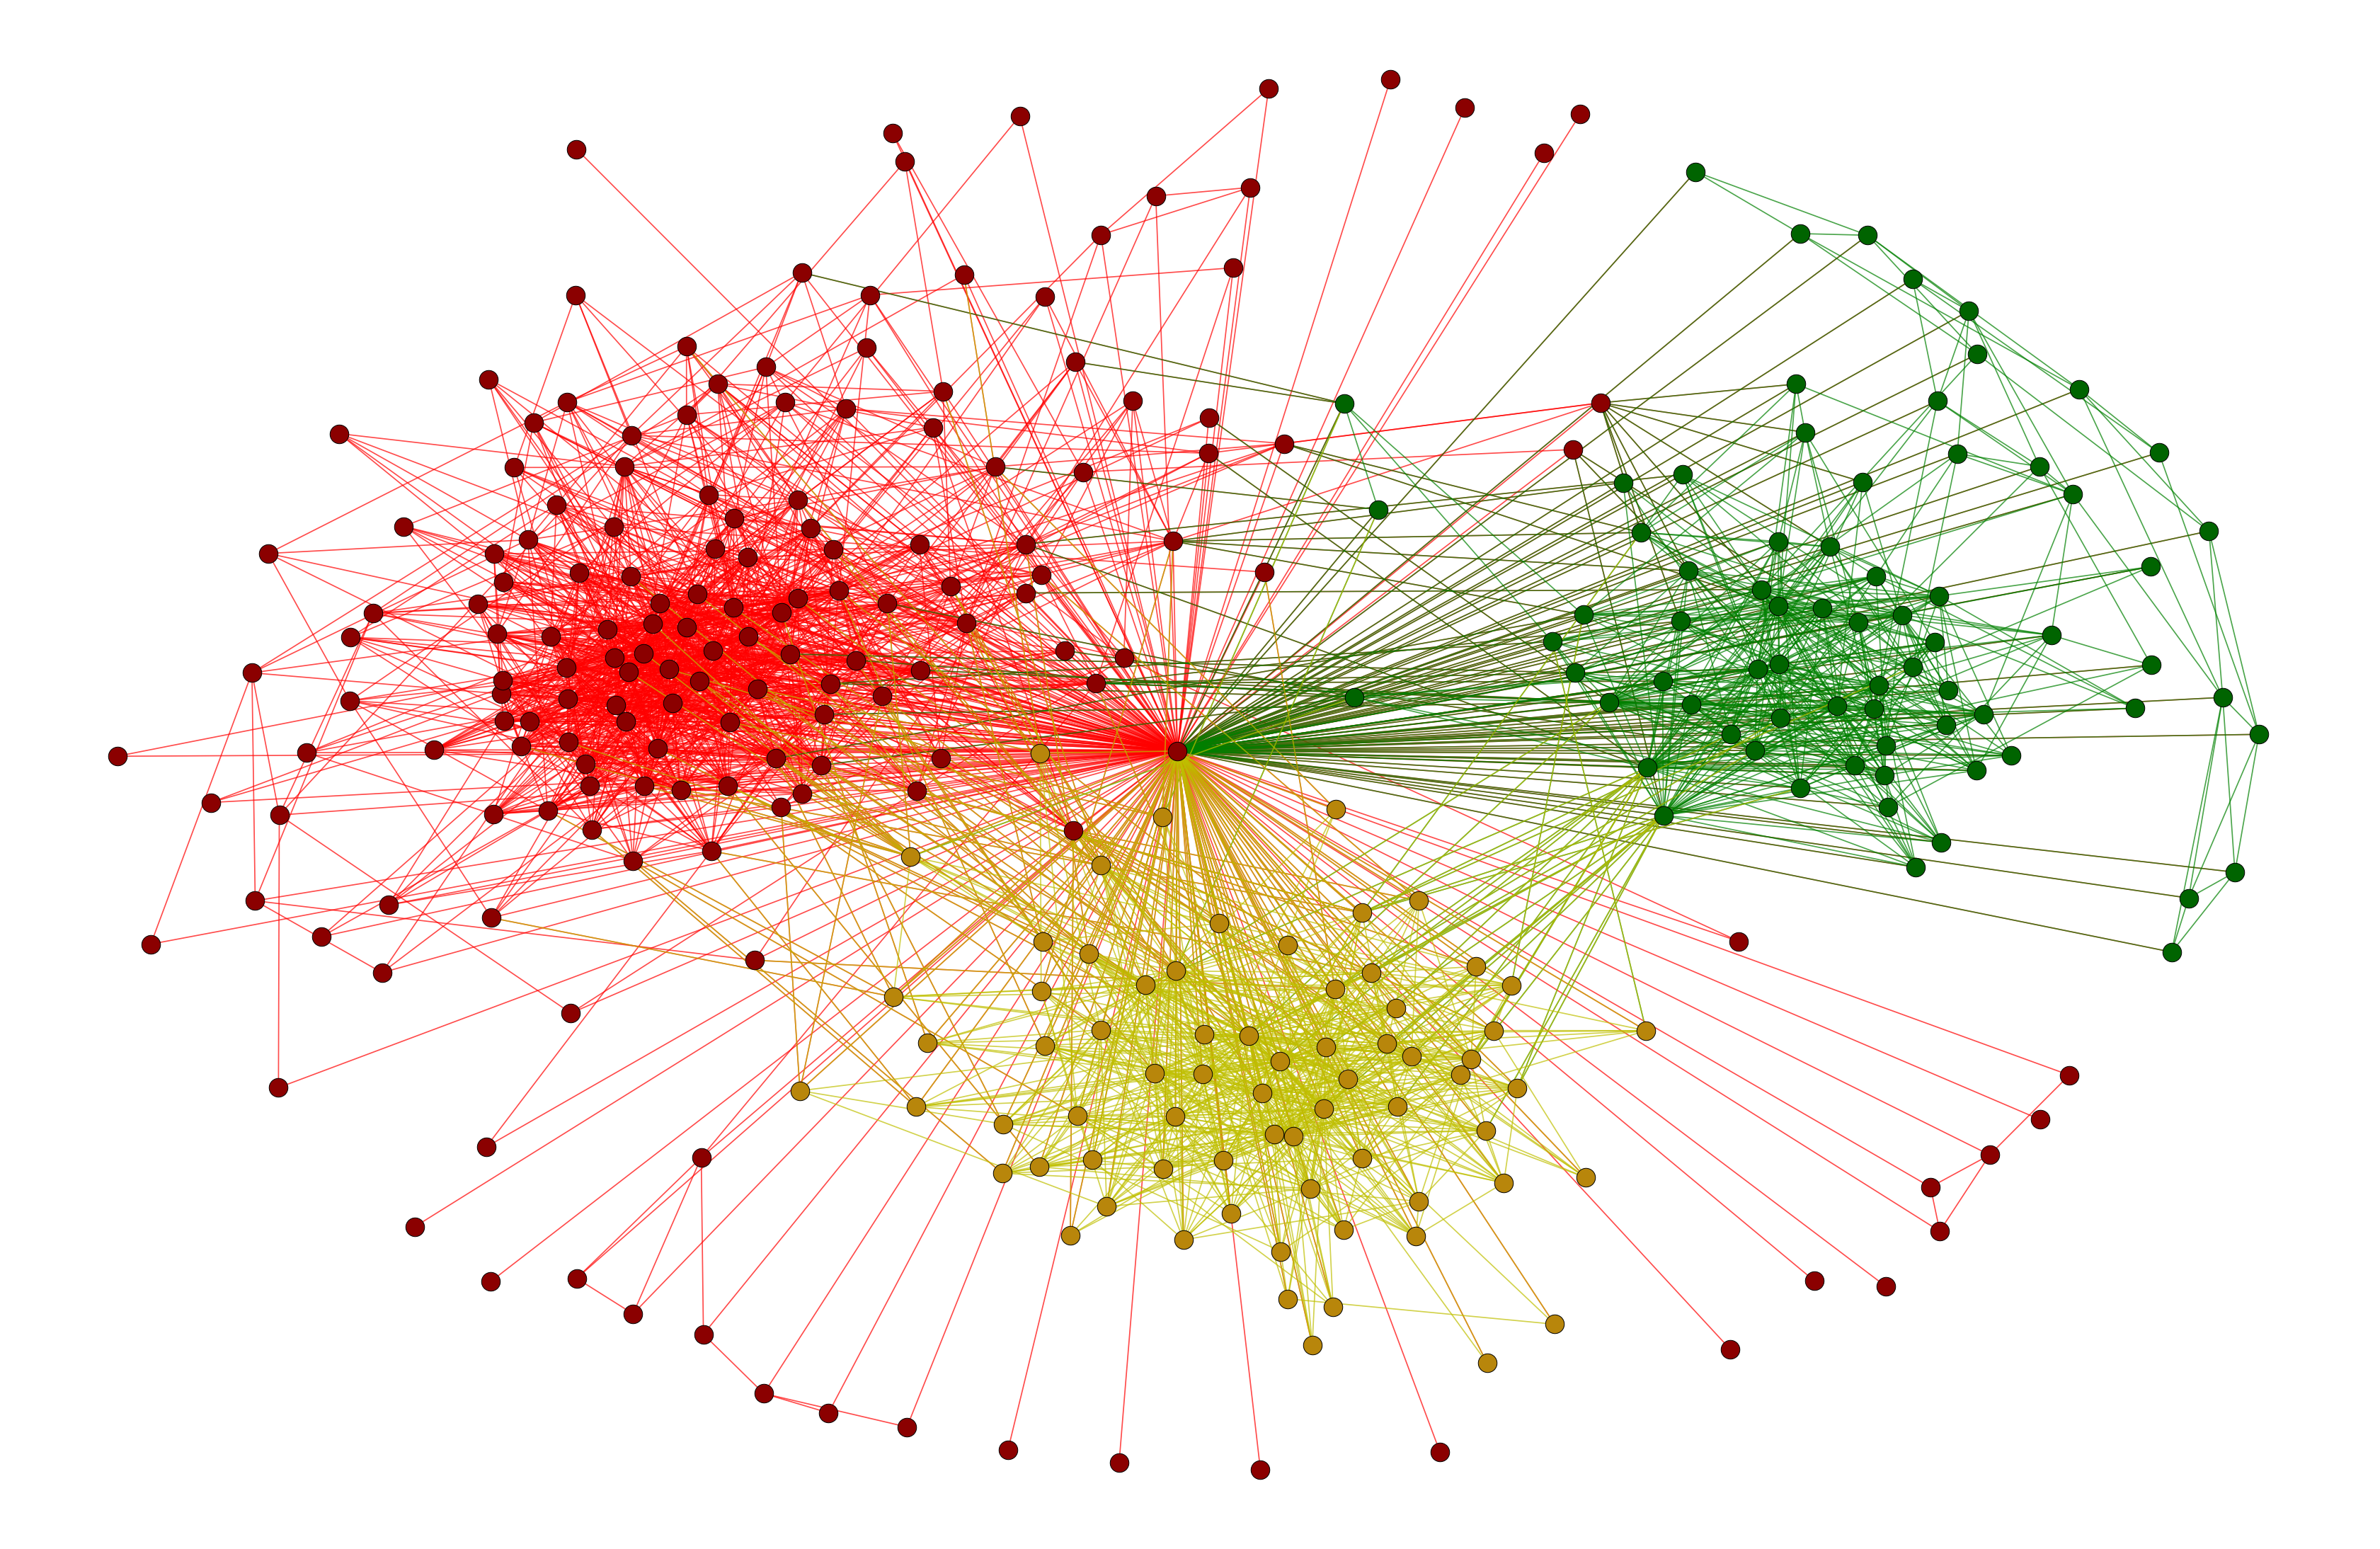

In [109]:
plt.figure(figsize=(60,40))
hub_ego = nx.ego_graph(graph, "Павел Богданов", radius=1)
pos = nx.spring_layout(hub_ego, seed=1)


# nx.draw_networkx_labels(hub_ego, pos, alpha=0.8, font_size=17)
# nx.draw_networkx_edges(hub_ego, pos, edgelist=my_edges, edge_color='k', alpha=0.8, width=2)

for i in range(len(modularity)):
    edgelist = [j for j in graph.edges if j[0] in list(modularity[i]) or j[1] in list(modularity[i])]
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=list(modularity[i]), node_color=['darkred', 'darkgreen', 'darkgoldenrod'][i], alpha=1, node_size=700, edgecolors='k')
    nx.draw_networkx_edges(hub_ego, pos, edgelist=edgelist, edge_color=['r', 'g', 'y'][i], alpha=0.7, width=1.7)

plt.axis('off')
plt.savefig('blob21.png')
plt.show()